<a href="https://colab.research.google.com/github/BenjamTorr/TDA_DeepL_TimeSeries/blob/main/StrarlightCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulos

In [1]:
!pip install giotto-tda

import numpy as np
from scipy.io import arff
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
from numpy import expand_dims
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
import hyperopt
import os
from sklearn.utils import shuffle
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from gtda.time_series import SingleTakensEmbedding

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.4 MB/s 
     |████████████████████████████████| 404 kB 54.2 MB/s 
     |████████████████████████████████| 3.1 MB 31.4 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.9.11-py3-none-any.whl size=9074 sha256=268422e8037d0b4a716ab4d8195d23904be3ea46494d9d8f6a69cc6b9bcbcc2e
  Stored in directory: /root/.cache/pip/wheels/7d/e4/0c/0c83f70bd0b99ce8aea47a21f8e52502169e7dd17808d12f30
Successfully built python-igraph


# Carga de datos y obtención curva de Betti


In [2]:
def load_data(path_train, path_test):
  """ Read data and labels from arff file and return X train X test and labels y, 
      in shape (n_samples, length, 1) and (n_samples)
      
      Parameters
      ----------
      path_train: string path of the train set
      path:test: string path of the test set

      Returns
      --------
      X_train: np array of shape (n_samples_train, ts_length) ts:= time series
      X_test: np.array of sahpe  (n_samples_test, ts_length)
      y_train: np. array of shape (n_samples_train,)
      y_test: np.array of shape (n_samples_test,)
  """
  #Train data
  data_train = arff.loadarff(path_train)
  df_train = (pd.DataFrame(data_train[0])).to_numpy()
  X_train = [df_train[i,:-1] for i in range(len(df_train))]
  y_train = [int(float(df_train[i,-1].decode('utf-8'))) - 1 for i in range(len(df_train[:,-1]))]
  #Test data
  data_test = arff.loadarff(path_test)
  df_test = (pd.DataFrame(data_test[0])).to_numpy()
  X_test = [df_test[i,:-1] for i in range(len(df_test))]
  y_test = [int(float(df_test[i,-1].decode('utf-8'))) - 1 for i in range(len(df_test[:,-1]))]

  return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def get_betti_curv(X_train, X_test, n_bins=200, max_edge_length=1):
  """Create the point Cloud from the time series using Takens' Embedding with parameters
     dimension=3, delay=1 and it calculates the homology of this point clouds to create the
     betti curves and then we create betti sequences

     Parameters
     ----------
     X_train: np array of shape (n_samples_train, ts_length)
     X_test: np.array of sahpe  (n_samples_test, ts_length)
     n_bins: number of points for a discretization of Betti Curves
     max_edge_length: Max length considered in Vietoris Rips complexes

     Returns
     --------
     BC_train: Betti curves of train data in shape (n_samples_train, 2, n_bins)
     BC_test: Betti curves of test data in shape (n_samples_test, 2, n_bins)
     Hom_train: Birth and death points of persistence diagram in train data
     Hom_test: Birth and death points of persistence diagrama in test data
     BC: Betti Curve Class fitted for visualization purposes
  """
  #Delay embedding in order to create cloud point in 3D
  TE = TakensEmbedding(time_delay=10, dimension=10)
  Embd_train = TE.fit_transform(X_train)
  Embd_test = TE.fit_transform(X_test)

  # Birth and death classes
  VR = VietorisRipsPersistence(max_edge_length=max_edge_length) # default homology_dimensions=(0,1)
  Hom_train = VR.fit_transform(Embd_train)
  Hom_test = VR.fit_transform(Embd_test)

  #Calculate Betti Curve
  BC = BettiCurve(n_bins = n_bins)
  BC_train = BC.fit_transform(Hom_train)
  BC_test = BC.fit_transform(Hom_test)
  return BC_train, BC_test, Hom_train, Hom_test, BC

def get_betti_seq(BC_train, BC_test, standarized = True):
  """Given the Betti Curves it creates the betti sequences with discretization mesh (n_bins) given
  function get_betti_curv

  Parameters
  -----------
  BC_train: np array of Betti Curves of train data set in shape  (n_samples_train, 2, n_bins)
  BC_test: Betti Curves of test data set in shape (n_samples_test, 2, n_bins)
  standarized: whether the betti sequence are going to be standarized or not

  Returns
  -------
  BS_train: np array Betti Sequences of train data set in shape (n_samples_train, 2 * n_bins, 1)
  BS_test: np array Betti Sequences of test data set in shape (n_samples_test, 2 * n_bins, 1)
  """
  BS_train = [np.concatenate([BC_train[i,0], BC_train[i,1]]) for i in range(len(BC_train))]
  BS_test = [np.concatenate([BC_test[i,0], BC_test[i,1]]) for i in range(len(BC_test))]
  if(standarized):
    BS_train = [(BS_train[i] - np.mean(BS_train[i])) / np.std(BS_train[i]) for i in range(len(BS_train))]
    BS_test = [(BS_test[i] - np.mean(BS_test[i])) / np.std(BS_test[i]) for i in range(len(BS_test))]
  return np.expand_dims(BS_train, axis=-1), np.expand_dims(BS_test, axis=-1)

def load_full(path_train, path_test, path_folder_save, n_bins=200, max_edge_length=1, standarized=True):
  """Using Only paths to the data, path to the folder where the data will be saved (should be empty if
  betti sequences has not been calculated) creates betti sequences ready to enter to a neural network

  Parameters
  ----------
  path_train: a string containing the path to the train data in arff extension
  path_test: a string containing the path to the test data in arff extension
  path_folder_save: a string cointaning the path to the folder where the data 
  sould be written after being calculated, it should be empty if the betti 
  seuqneces has not been calculated, if they have already been calculated it 
  should have the data in txt formata
  n_bins: number of points for a discretization of Betti Curves
  max_edge_length: Max length considered in Vietoris Rips complexes
  standarized: whether the betti sequence are going to be standarized or not

  Returns
  --------
  BS_train: np array Betti Sequences of train data set in shape (n_samples_train, 2 * n_bins, 1)
  BS_test: np array Betti Sequences of test data set in shape (n_samples_test, 2 * n_bins, 1)
  y_train: np. array of shape (n_samples_train,)
  y_test: np.array of shape (n_samples_test,)
  Hom_train: Birth and death points of persistence diagram in train data
  Hom_test: Birth and death points of persistence diagrama in test data
  """
  if len(os.listdir(path_folder_save)) == 0: #Check if the data has already been calculated
    X_train, X_test, y_train, y_test = load_data(path_train, path_test)
    BC_train, BC_test, Hom_train, Hom_test, BC = get_betti_curv(X_train, X_test, n_bins=n_bins, max_edge_length=max_edge_length)
    BS_train, BS_test = get_betti_seq(BC_train, BC_test, standarized=standarized)
    to_save =[BS_train, BS_test, Hom_train, Hom_test, np.expand_dims(y_train,axis=-1), np.expand_dims(y_test,axis=-1)]
    paths = ['BS_train', 'BS_test', 'Hom_train', 'Hom_test', 'y_train', 'y_test']
    for i in range(len(paths)):
      file = open(path_folder_save + '/' + paths[i] + '.txt', "w")
      for row in to_save[i]:
        np.savetxt(file, row)
      file.close()
  else:
    #Load the precalculated data
    BS_train = np.loadtxt(path_folder_save + '/BS_train.txt')
    BS_test = np.loadtxt(path_folder_save + '/BS_test.txt')
    Hom_train = np.loadtxt(path_folder_save + '/Hom_train.txt')
    Hom_test = np.loadtxt(path_folder_save + '/Hom_test.txt')
    y_train = np.loadtxt(path_folder_save + '/y_train.txt')
    y_test = np.loadtxt(path_folder_save + '/y_test.txt')
    #reshape data
    samples_train = int(len(BS_train) / (2 * n_bins))
    samples_test = int(len(BS_test) / (2 * n_bins))
    BS_train = BS_train.reshape(samples_train, int(2 * n_bins), 1)
    BS_test = BS_test.reshape(samples_test, int(2 * n_bins), 1)
    Hom_train = Hom_train.reshape(samples_train,int(len(Hom_train) / (samples_train)), 3)
    Hom_test = Hom_test.reshape(samples_test,int(len(Hom_test) / (samples_test)), 3)
  return BS_train, BS_test, y_train, y_test, Hom_train, Hom_test


# Lectura de datos, cálculo guardado y de secuencias de Betti y

In [3]:
training_path = '/content/drive/MyDrive/Analysis Data/Starlights/Train/StarLightCurves_TRAIN.arff' 
test_path = '/content/drive/MyDrive/Analysis Data/Starlights/Test/StarLightCurves_TEST.arff'
save_folder = '/content/drive/MyDrive/Analysis Data/Starlights/Betti_saved_1020'

In [4]:
BS_train, BS_test, y_train, y_test, Hom_train, Hom_test = load_full(training_path, test_path, save_folder, n_bins=150, max_edge_length=0.2)

# Analisis Series de tiempo

In [ ]:
TS_train, TS_tes, _,_ = load_data(training_path, test_path)

In [ ]:
delay = np.zeros(len(TS_train))
dimension = np.zeros(len(TS_train))

for i in range(len(TS_train)):
  TE = SingleTakensEmbedding(parameters_type = 'search', time_delay=40, dimension=20)
  ts_embedd = TE.fit_transform(TS_train[i].astype(float))
  delay[i] = TE.time_delay_
  dimension[i] = TE.dimension_

In [ ]:
df = pd.DataFrame({"clases" : y_train, "dimension": dimension, "delay": delay})

<Figure size 2160x1440 with 0 Axes>

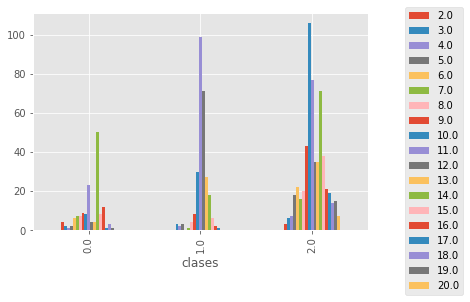

In [ ]:
plt.figure(figsize=(30,20))
plt.style.use('ggplot')
df.groupby(['clases', 'dimension'])\
      .dimension.count().unstack().plot.bar(legend=True)
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

<Figure size 1440x720 with 0 Axes>

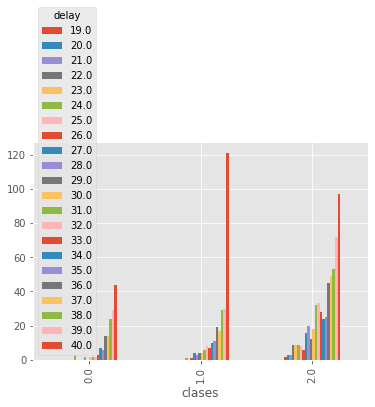

In [ ]:
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
df.groupby(['clases', 'delay'])\
      .delay.count().unstack().plot.bar(legend=True)

plt.show()

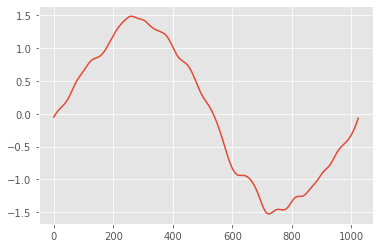

In [ ]:
plt.plot(TS_train[2])

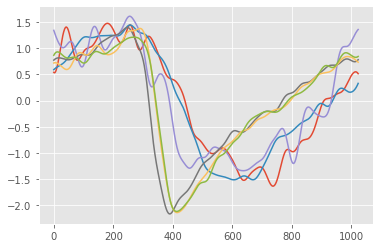

In [ ]:
clase = 2
muestra = 5

idx = 0

for i in range(len(TS_train)):
  if y_train[i] == clase and idx <= muestra :
    plt.plot(TS_train[i])
    idx = idx + 1

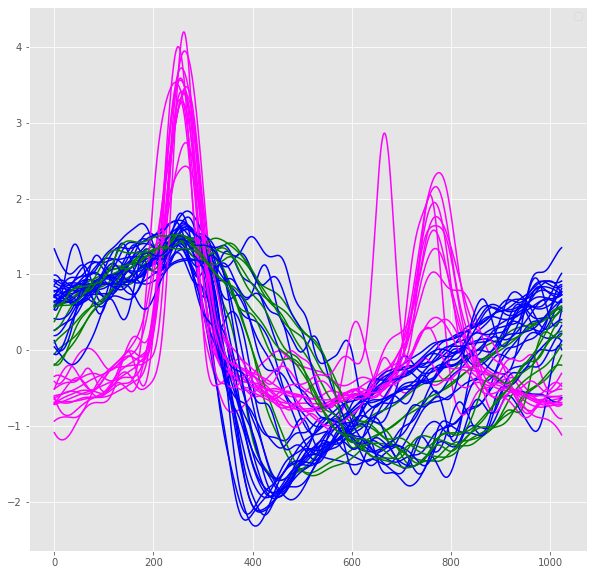

In [ ]:
color =["green", "magenta", "blue"]
from matplotlib.pyplot import figure

plt.figure(figsize=(10,10))
muestra = 50
legends = []
for i in range(muestra):
    plt.plot(TS_train[i], color = color[int(y_train[i])])
plt.legend(legends)

In [ ]:
fig = px.histogram(y_train, nbins=len(np.unique(y_train)))
fig.show()

In [ ]:
BC = BettiCurve(n_bins = 150)
Bc = BC.fit_transform(Hom_train)
BC.plot(Bc,sample=100)

# Modelo

In [ ]:
BS_train_model, BS_val, y_train_model, y_val = train_test_split(BS_train, y_train, test_size = 0.2, random_state=30)

In [ ]:
def evaluar_modelo(BS_train, y_train, BS_val, y_val, balanced, verbose1):
  model = keras.models.Sequential([
      keras.layers.Conv1D(64, 9, activation="relu", padding="valid", input_shape=(300, 1)),
      keras.layers.MaxPooling1D(2),
      keras.layers.Conv1D(32, 7, activation="relu", padding="same"),
      keras.layers.MaxPooling1D(3),
      keras.layers.Dropout(0.3),
      keras.layers.Conv1D(32,5, activation="relu"),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation="relu"),
      keras.layers.Dense(64, activation="relu"),
      keras.layers.Dense(3, activation="softmax")
  ])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
  model.compile(loss = "categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  epochs=22
  if balanced == 1:
      values = class_weight.compute_class_weight(class_weight="balanced",classes = np.unique(y_train), y=y_train)
      keys = list(range(len(np.unique(y_train))))
      pesos = dict(zip(keys,values))
      history = model.fit(BS_train, keras.utils.to_categorical(y_train), epochs=epochs, validation_data=(BS_val, keras.utils.to_categorical(y_val)), class_weight = pesos, verbose = verbose1)
  else:
      history = model.fit(BS_train, keras.utils.to_categorical(y_train), epochs=epochs, validation_data=(BS_val, keras.utils.to_categorical(y_val)), verbose = verbose1)

  return history, model

Epoch 1/22
25/25 [==============================] - 2s 47ms/step - loss: 0.5885 - accuracy: 0.7125 - val_loss: 0.5093 - val_accuracy: 0.7900
Epoch 2/22
25/25 [==============================] - 1s 38ms/step - loss: 0.4059 - accuracy: 0.7937 - val_loss: 0.4012 - val_accuracy: 0.8450
Epoch 3/22
25/25 [==============================] - 1s 38ms/step - loss: 0.3482 - accuracy: 0.7887 - val_loss: 0.3872 - val_accuracy: 0.8300
Epoch 4/22
25/25 [==============================] - 1s 38ms/step - loss: 0.3680 - accuracy: 0.8163 - val_loss: 0.5037 - val_accuracy: 0.8050
Epoch 5/22
25/25 [==============================] - 1s 37ms/step - loss: 0.3566 - accuracy: 0.8163 - val_loss: 0.3381 - val_accuracy: 0.8850
Epoch 6/22
25/25 [==============================] - 1s 39ms/step - loss: 0.3064 - accuracy: 0.8263 - val_loss: 0.3200 - val_accuracy: 0.9150
Epoch 7/22
25/25 [==============================] - 1s 37ms/step - loss: 0.3160 - accuracy: 0.8687 - val_loss: 0.4506 - val_accuracy: 0.8550
Epoch 8/22
25

<function matplotlib.pyplot.show>

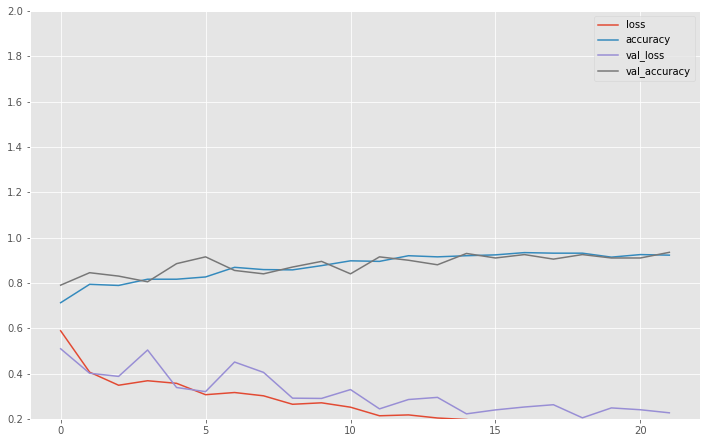

In [ ]:
history, model = evaluar_modelo(BS_train_model,y_train_model,BS_val, y_val, 1,1)

pd.DataFrame(history.history).plot(figsize=(12,7.5))
plt.grid(True)
plt.gca().set_ylim(0.2,2)
plt.show


# Evaluación datos validación

In [ ]:
y_pred = model.predict(BS_val)

In [ ]:
CM = tf.math.confusion_matrix(y_val, y_pred.argmax(axis=1))

fig = px.imshow(CM, color_continuous_scale="inferno")
fig.show()

In [ ]:
print(classification_report(y_val, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88        31
           1       0.97      0.97      0.97        58
           2       0.95      0.94      0.95       111

    accuracy                           0.94       200
   macro avg       0.92      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



# Hyperparameter Tuning | Bayesian Opt

In [ ]:
#Definimos rango de valores en el cual deseamos encontrar el óptimo

kernel_units_options = np.arange(1, 60 + 1, 5, dtype=int)
kernel_size_options = np.arange(3, 14 + 1, 1, dtype=int)
dropout_options = np.arange(.20,.75 + 0.01, 0.025, dtype=float)
batchsize_options = np.arange(32, 128 + 1, 20, dtype=int)
epochs_options = np.arange(10, 100, 10, dtype=int)
MaxPool_options = np.arange(2, 3, 1, dtype=int)
dense_options = np.arange(10, 300, 30, dtype=int)
dense_options2 = np.arange(10, 128, 20, dtype=int)
space = {
            'units1': hp.choice('units1', kernel_units_options),
            'units2': hp.choice('units2', kernel_units_options), 
            'size1':hp.choice('size1', kernel_size_options),
            'size2':hp.choice('size2', kernel_size_options), 
            'pool1': hp.choice('pool1', MaxPool_options),         
            'dropout1': hp.choice('dropout1', dropout_options),
            'dropout2': hp.choice('dropout2', dropout_options),

            'batch_size' : hp.choice('batch_size', batchsize_options),

            'nb_epochs' :  hp.choice('epochs_options', epochs_options),
            'dense1': hp.choice('dense1',dense_options),
            'dense2':hp.choice('dense2', dense_options2),
        }

In [ ]:
def f_nn(params):
  model = keras.models.Sequential([
      keras.layers.Conv1D(params['units1'], {params['size1']}, activation="relu", input_shape=(300, 1)),
      keras.layers.Conv1D(params['units2'], {params['size2']}, activation="relu"),
      keras.layers.Dropout(params['dropout1']),
      keras.layers.MaxPooling1D({params['pool1']}),
      keras.layers.Flatten(),
      keras.layers.Dense(params['dense1'], activation="relu"),
      keras.layers.Dropout(params['dropout2']),
      keras.layers.Dense(params['dense2'], activation="relu"),
      keras.layers.Dense(3, activation="softmax")
  ])
  model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  history = model.fit(BS_train_model, keras.utils.to_categorical(y_train_model), epochs=params['nb_epochs'], validation_data = (BS_val, keras.utils.to_categorical(y_val)), verbose = 0, batch_size=params['batch_size'])
  loss = history.history['val_loss'][-1]
  a,acc = model.evaluate(BS_val, keras.utils.to_categorical(y_val))
  print("AUC: %.5f" % (history.history['val_accuracy'][-1]))
  print("LOSS: %.5f" % (loss))
  return {'loss': -acc, 'status': STATUS_OK}

In [ ]:
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=300, trials=trials)
print('\nBest params found:\n', best)


with open('/content/drive/MyDrive/Analysis Data/Starlights/Bayopt/hyp02_acc1010.txt', 'w') as f:
    print(best, file=f)

7/7 [==============================] - 0s 17ms/step - loss: 0.2000 - accuracy: 0.9450

AUC: 0.94500
LOSS: 0.20003
7/7 [==============================] - 0s 7ms/step - loss: 0.3704 - accuracy: 0.9200

AUC: 0.92000
LOSS: 0.37044
7/7 [==============================] - 0s 14ms/step - loss: 0.2036 - accuracy: 0.9250

AUC: 0.92500
LOSS: 0.20360
7/7 [==============================] - 0s 21ms/step - loss: 0.1825 - accuracy: 0.9350

AUC: 0.93500
LOSS: 0.18247
7/7 [==============================] - 0s 16ms/step - loss: 0.2208 - accuracy: 0.9400

AUC: 0.94000
LOSS: 0.22085
7/7 [==============================] - 0s 15ms/step - loss: 0.2520 - accuracy: 0.9500

AUC: 0.95000
LOSS: 0.25198
7/7 [==============================] - 0s 23ms/step - loss: 0.2228 - accuracy: 0.9250

AUC: 0.92500
LOSS: 0.22284
7/7 [==============================] - 0s 22ms/step - loss: 0.3926 - accuracy: 0.7900

AUC: 0.79000
LOSS: 0.39258
7/7 [==============================] - 0s 8ms/step - loss: 0.2073 - accuracy: 0.9250

AUC

In [ ]:
import ast

file = open("/content/drive/MyDrive/Analysis Data/Starlights/Bayopt/hyp02_acc1010.txt", "r")


contents = file.read()

parametros_guardados = ast.literal_eval(contents)


file.close()

In [ ]:
hyperopt.space_eval(space, parametros_guardados)

{'batch_size': 32,
 'dense1': 220,
 'dense2': 70,
 'dropout1': 0.2,
 'dropout2': 0.4749999999999999,
 'nb_epochs': 70,
 'pool1': 2,
 'size1': 6,
 'size2': 14,
 'units1': 16,
 'units2': 11}

In [ ]:
parametros_guardados

{'batch_size': 0,
 'dense1': 7,
 'dense2': 3,
 'dropout1': 0,
 'dropout2': 11,
 'epochs_options': 6,
 'pool1': 0,
 'size1': 3,
 'size2': 11,
 'units1': 3,
 'units2': 2}

In [ ]:
# Modelo encontrado por optimización bayesiana

def evaluar_modelo_bayopt(BS_train, y_train, BS_val, y_val, balanced, verbose1):
  model = keras.models.Sequential([
      keras.layers.Conv1D(int(kernel_units_options[3]), int(kernel_size_options[3]), activation="relu", padding="valid", input_shape=(300, 1)),
      keras.layers.Conv1D(int(kernel_units_options[2]), int(kernel_size_options[11]), activation="relu", padding="same"),
      keras.layers.Dropout(float(dropout_options[0])),
      keras.layers.MaxPooling1D(int(MaxPool_options[0])),
      keras.layers.Flatten(),
      keras.layers.Dense(int(dense_options[7]), activation="relu"),
      keras.layers.Dropout(int(dropout_options[11])),
      keras.layers.Dense(int(dense_options2[3]), activation="relu"),
      keras.layers.Dense(3, activation="softmax")
  ])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
  model.compile(loss = "categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  #epochs=int(epochs_options[6])
  epochs = 33
  if balanced == 1:
      values = class_weight.compute_class_weight(class_weight="balanced",classes = np.unique(y_train), y=y_train)
      keys = list(range(len(np.unique(y_train))))
      pesos = dict(zip(keys,values))
      history = model.fit(BS_train, keras.utils.to_categorical(y_train), epochs=epochs, validation_data=(BS_val, keras.utils.to_categorical(y_val)), class_weight = pesos, verbose = verbose1, batch_size=batchsize_options[0])
  else:
      history = model.fit(BS_train, keras.utils.to_categorical(y_train), epochs=epochs, validation_data=(BS_val, keras.utils.to_categorical(y_val)), verbose = verbose1, batch_size=int(batchsize_options[0]))

  return history, model

Epoch 1/33
25/25 [==============================] - 2s 37ms/step - loss: 0.4660 - accuracy: 0.8138 - val_loss: 0.3843 - val_accuracy: 0.8850
Epoch 2/33
25/25 [==============================] - 1s 30ms/step - loss: 0.2279 - accuracy: 0.9262 - val_loss: 0.2663 - val_accuracy: 0.8950
Epoch 3/33
25/25 [==============================] - 1s 30ms/step - loss: 0.2497 - accuracy: 0.9162 - val_loss: 0.2941 - val_accuracy: 0.8900
Epoch 4/33
25/25 [==============================] - 1s 29ms/step - loss: 0.2017 - accuracy: 0.9287 - val_loss: 0.2792 - val_accuracy: 0.8750
Epoch 5/33
25/25 [==============================] - 1s 29ms/step - loss: 0.1731 - accuracy: 0.9362 - val_loss: 0.2296 - val_accuracy: 0.9050
Epoch 6/33
25/25 [==============================] - 1s 30ms/step - loss: 0.1565 - accuracy: 0.9538 - val_loss: 0.1953 - val_accuracy: 0.9300
Epoch 7/33
25/25 [==============================] - 1s 29ms/step - loss: 0.1449 - accuracy: 0.9500 - val_loss: 0.1981 - val_accuracy: 0.9100
Epoch 8/33
25

<function matplotlib.pyplot.show>

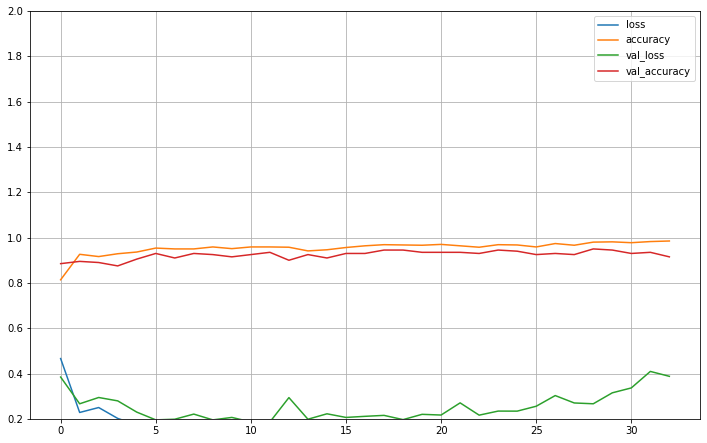

In [ ]:
history_bayopt, model_bayopt = evaluar_modelo_bayopt(BS_train_model,y_train_model,BS_val, y_val, 0,1)

pd.DataFrame(history_bayopt.history).plot(figsize=(12,7.5))
plt.grid(True)
plt.gca().set_ylim(0.2,2)
plt.show


# Salvar el modelo

In [ ]:
model_bayopt.save('/content/drive/MyDrive/Analysis Data/Starlights/models/seq02_102095bayopt')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Analysis Data/Starlights/models/seq02_102095bayopt/assets


# Evaluación Final

In [5]:
from keras.models import load_model

model_eval = load_model('/content/drive/MyDrive/Analysis Data/Starlights/models/seq02_102095')

In [6]:
y_pred = model_eval.predict(BS_test)
CM = tf.math.confusion_matrix(y_test, y_pred.argmax(axis=1))

fig = px.imshow(CM, color_continuous_scale="inferno")
fig.show()

In [8]:
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87      1177
         1.0       0.94      0.97      0.96      2305
         2.0       0.95      0.94      0.95      4754

    accuracy                           0.94      8236
   macro avg       0.92      0.93      0.93      8236
weighted avg       0.94      0.94      0.94      8236



In [9]:
def validar_modelo(BS_train, y_train, balanced, verbose1):
  model = keras.models.Sequential([
      keras.layers.Conv1D(64, 9, activation="relu", padding="valid", input_shape=(300, 1)),
      keras.layers.MaxPooling1D(2),
      keras.layers.Conv1D(32, 7, activation="relu", padding="same"),
      keras.layers.MaxPooling1D(3),
      keras.layers.Dropout(0.3),
      keras.layers.Conv1D(32,5, activation="relu"),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation="relu"),
      keras.layers.Dense(64, activation="relu"),
      keras.layers.Dense(3, activation="softmax")
  ])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
  model.compile(loss = "categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  epochs=22
  if balanced == 1:
      values = class_weight.compute_class_weight(class_weight="balanced",classes = np.unique(y_train), y=y_train)
      keys = list(range(len(np.unique(y_train))))
      pesos = dict(zip(keys,values))
      history = model.fit(BS_train, keras.utils.to_categorical(y_train), epochs=epochs, class_weight = pesos, verbose = verbose1)
  else:
      history = model.fit(BS_train, keras.utils.to_categorical(y_train), epochs=epochs,  verbose = verbose1)

  return history, model

In [10]:
BS = np.concatenate([BS_train,BS_test])
y = np.concatenate([y_train, y_test])

In [ ]:
from sklearn.utils import resample
results = np.zeros(100)
for i in range(100):
  BS_, y_ = resample(BS, y, random_state=i)
  data_train = BS_[0:1000]
  data_test = BS_[1000:]
  target_train = y_[0:1000]
  target_test = y_[1000:]
  _, model_sam = validar_modelo(data_train, target_train, 1, 0)
  a, acc = model_sam.evaluate(data_test, keras.utils.to_categorical(target_test))
  results[i] = acc

258/258 [==============================] - 3s 9ms/step - loss: 0.2464 - accuracy: 0.9299


In [ ]:
print(results.mean())
print(results.std())

0.9257248646020889
0.01734367535717743


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
kf.get_n_splits(BS)
results_10fold = np.zeros(10)
idx = 0
for train_index, test_index in kf.split(BS):
  data_train = BS[train_index]
  data_test = BS[test_index]
  target_train = y[train_index]
  target_test = y[test_index]
  _, model_sam = validar_modelo(data_train, target_train, 1, 0)
  a, acc = model_sam.evaluate(data_test, keras.utils.to_categorical(target_test))
  results_10fold[idx] = acc
  idx += 1
print(results_10fold.mean())
print(results_10fold.std())

In [ ]:
from sklearn.model_selection import LeaveOneOut

results_loo = np.zeros(9236)
loo = LeaveOneOut()
loo.get_n_splits(BS)
idx = 0
for train_index, test_index in loo.split(BS):
  data_train = BS[train_index]
  data_test = BS[test_index]
  target_train = y[train_index]
  target_test = y[test_index]
  _, model_sam = validar_modelo(data_train, target_train, 1, 0)
  a, acc = model_sam.evaluate(data_test, keras.utils.to_categorical(target_test))
  results_loo[idx] = acc
  idx += 1  
print(results_loo.mean())
print(results_loo.std())

# 4ta forma

In [ ]:
def validar_modelo_wth_splt(BS_train, y_train, balanced, verbose1):
  model = keras.models.Sequential([
      keras.layers.Conv1D(64, 9, activation="relu", padding="valid", input_shape=(300, 1)),
      keras.layers.MaxPooling1D(2),
      keras.layers.Conv1D(32, 7, activation="relu", padding="same"),
      keras.layers.MaxPooling1D(3),
      keras.layers.Dropout(0.3),
      keras.layers.Conv1D(32,5, activation="relu"),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation="relu"),
      keras.layers.Dense(64, activation="relu"),
      keras.layers.Dense(3, activation="softmax")
  ])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
  model.compile(loss = "categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  epochs=22
  if balanced == 1:
      values = class_weight.compute_class_weight(class_weight="balanced",classes = np.unique(y_train), y=y_train)
      keys = list(range(len(np.unique(y_train))))
      pesos = dict(zip(keys,values))
      history = model.fit(BS_train, keras.utils.to_categorical(y_train), epochs=epochs, validation_split=0.2, class_weight = pesos, verbose = verbose1)
  else:
      history = model.fit(BS_train, keras.utils.to_categorical(y_train), epochs=epochs, validation_split=0.2, verbose = verbose1)

  return history.history['val_accuracy'][-1], model

In [ ]:
def get_best_model(BS_train, y_train, iterations=5):
  best_val_acc = 0
  for i in range(iterations):
    acc, model_loc = validar_modelo_wth_splt(BS_train, y_train,1,0)
    if acc > best_val_acc:
      best_val_acc = acc
      model = model_loc
  return model 

In [ ]:
results_max = np.zeros(100)
for i in range(100):
  BS_, y_ = resample(BS, y, random_state=i)
  data_train = BS_[0:1000]
  data_test = BS_[1000:]
  target_train = y_[0:1000]
  target_test = y_[1000:]
  model_sam = get_best_model(data_train,  target_train, 5)
  a, acc = model_sam.evaluate(data_test, keras.utils.to_categorical(target_test))
  results_max[i] = acc
print(results_max.avg())
print(results_max.std())